# تحميل (استيراد) المكتبات الأساسية
# Importing

In [1]:
import os
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import calendar

# إدخال بيانات التواريخ
# Input dates

In [2]:
# --- User Input ---
year = 2006
month = 12
start_day = 13
end_day = 16

# العمليات علي الأيام و السنين

In [3]:
# --- Validate Day Range ---
last_day = calendar.monthrange(year, month)[1]
end_day = min(end_day, last_day)

# --- Date Strings ---
year_str = f"{year}"
month_str = f"{month:02d}"
start_str = f"{year}{month_str}01"
end_str = f"{year}{month_str}{last_day:02d}"

#  فحص الأقمار الصناعية GOSE
# و عرض المتاح منها

🔍 Trying GOES-01...
❌ GOES-01 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-02...
❌ GOES-02 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-03...
❌ GOES-03 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-04...
❌ GOES-04 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-05...
❌ GOES-05 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-06...
❌ GOES-06 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-07...
❌ GOES-07 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-08...
❌ GOES-08 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-09...
❌ GOES-09 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-10...
✅ Data downloaded for GOES-10


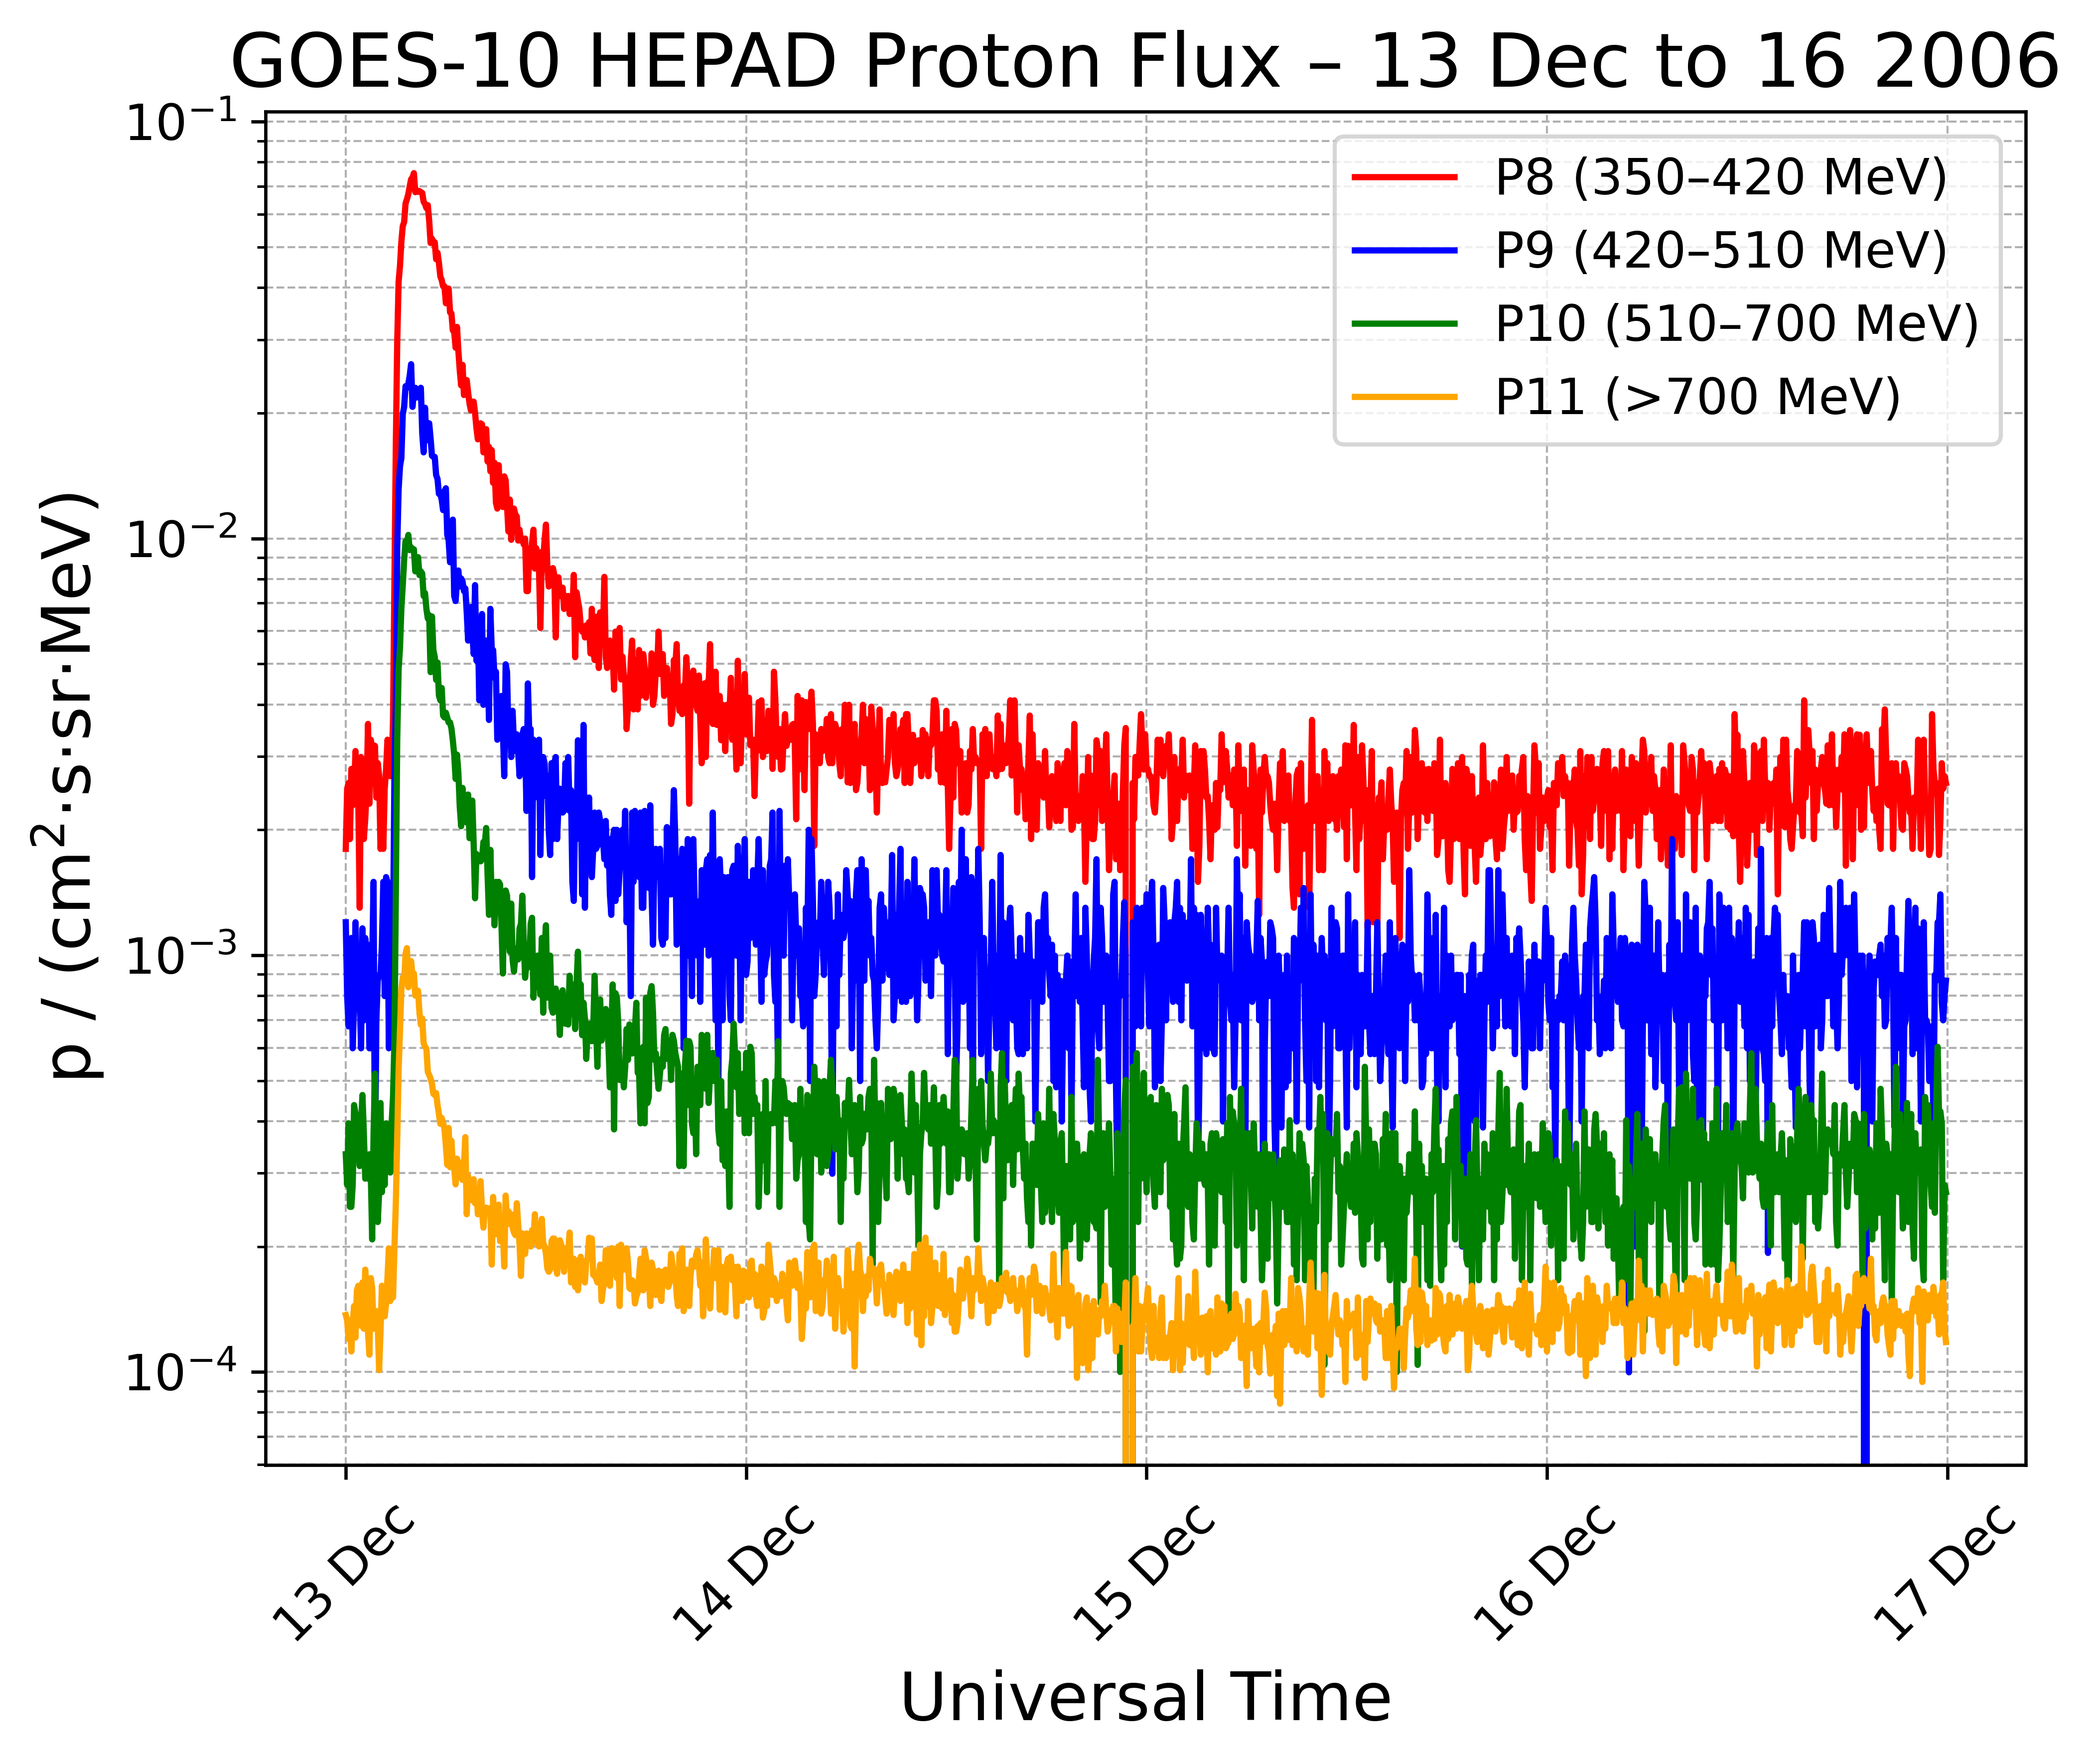

🔍 Trying GOES-11...
✅ Data downloaded for GOES-11


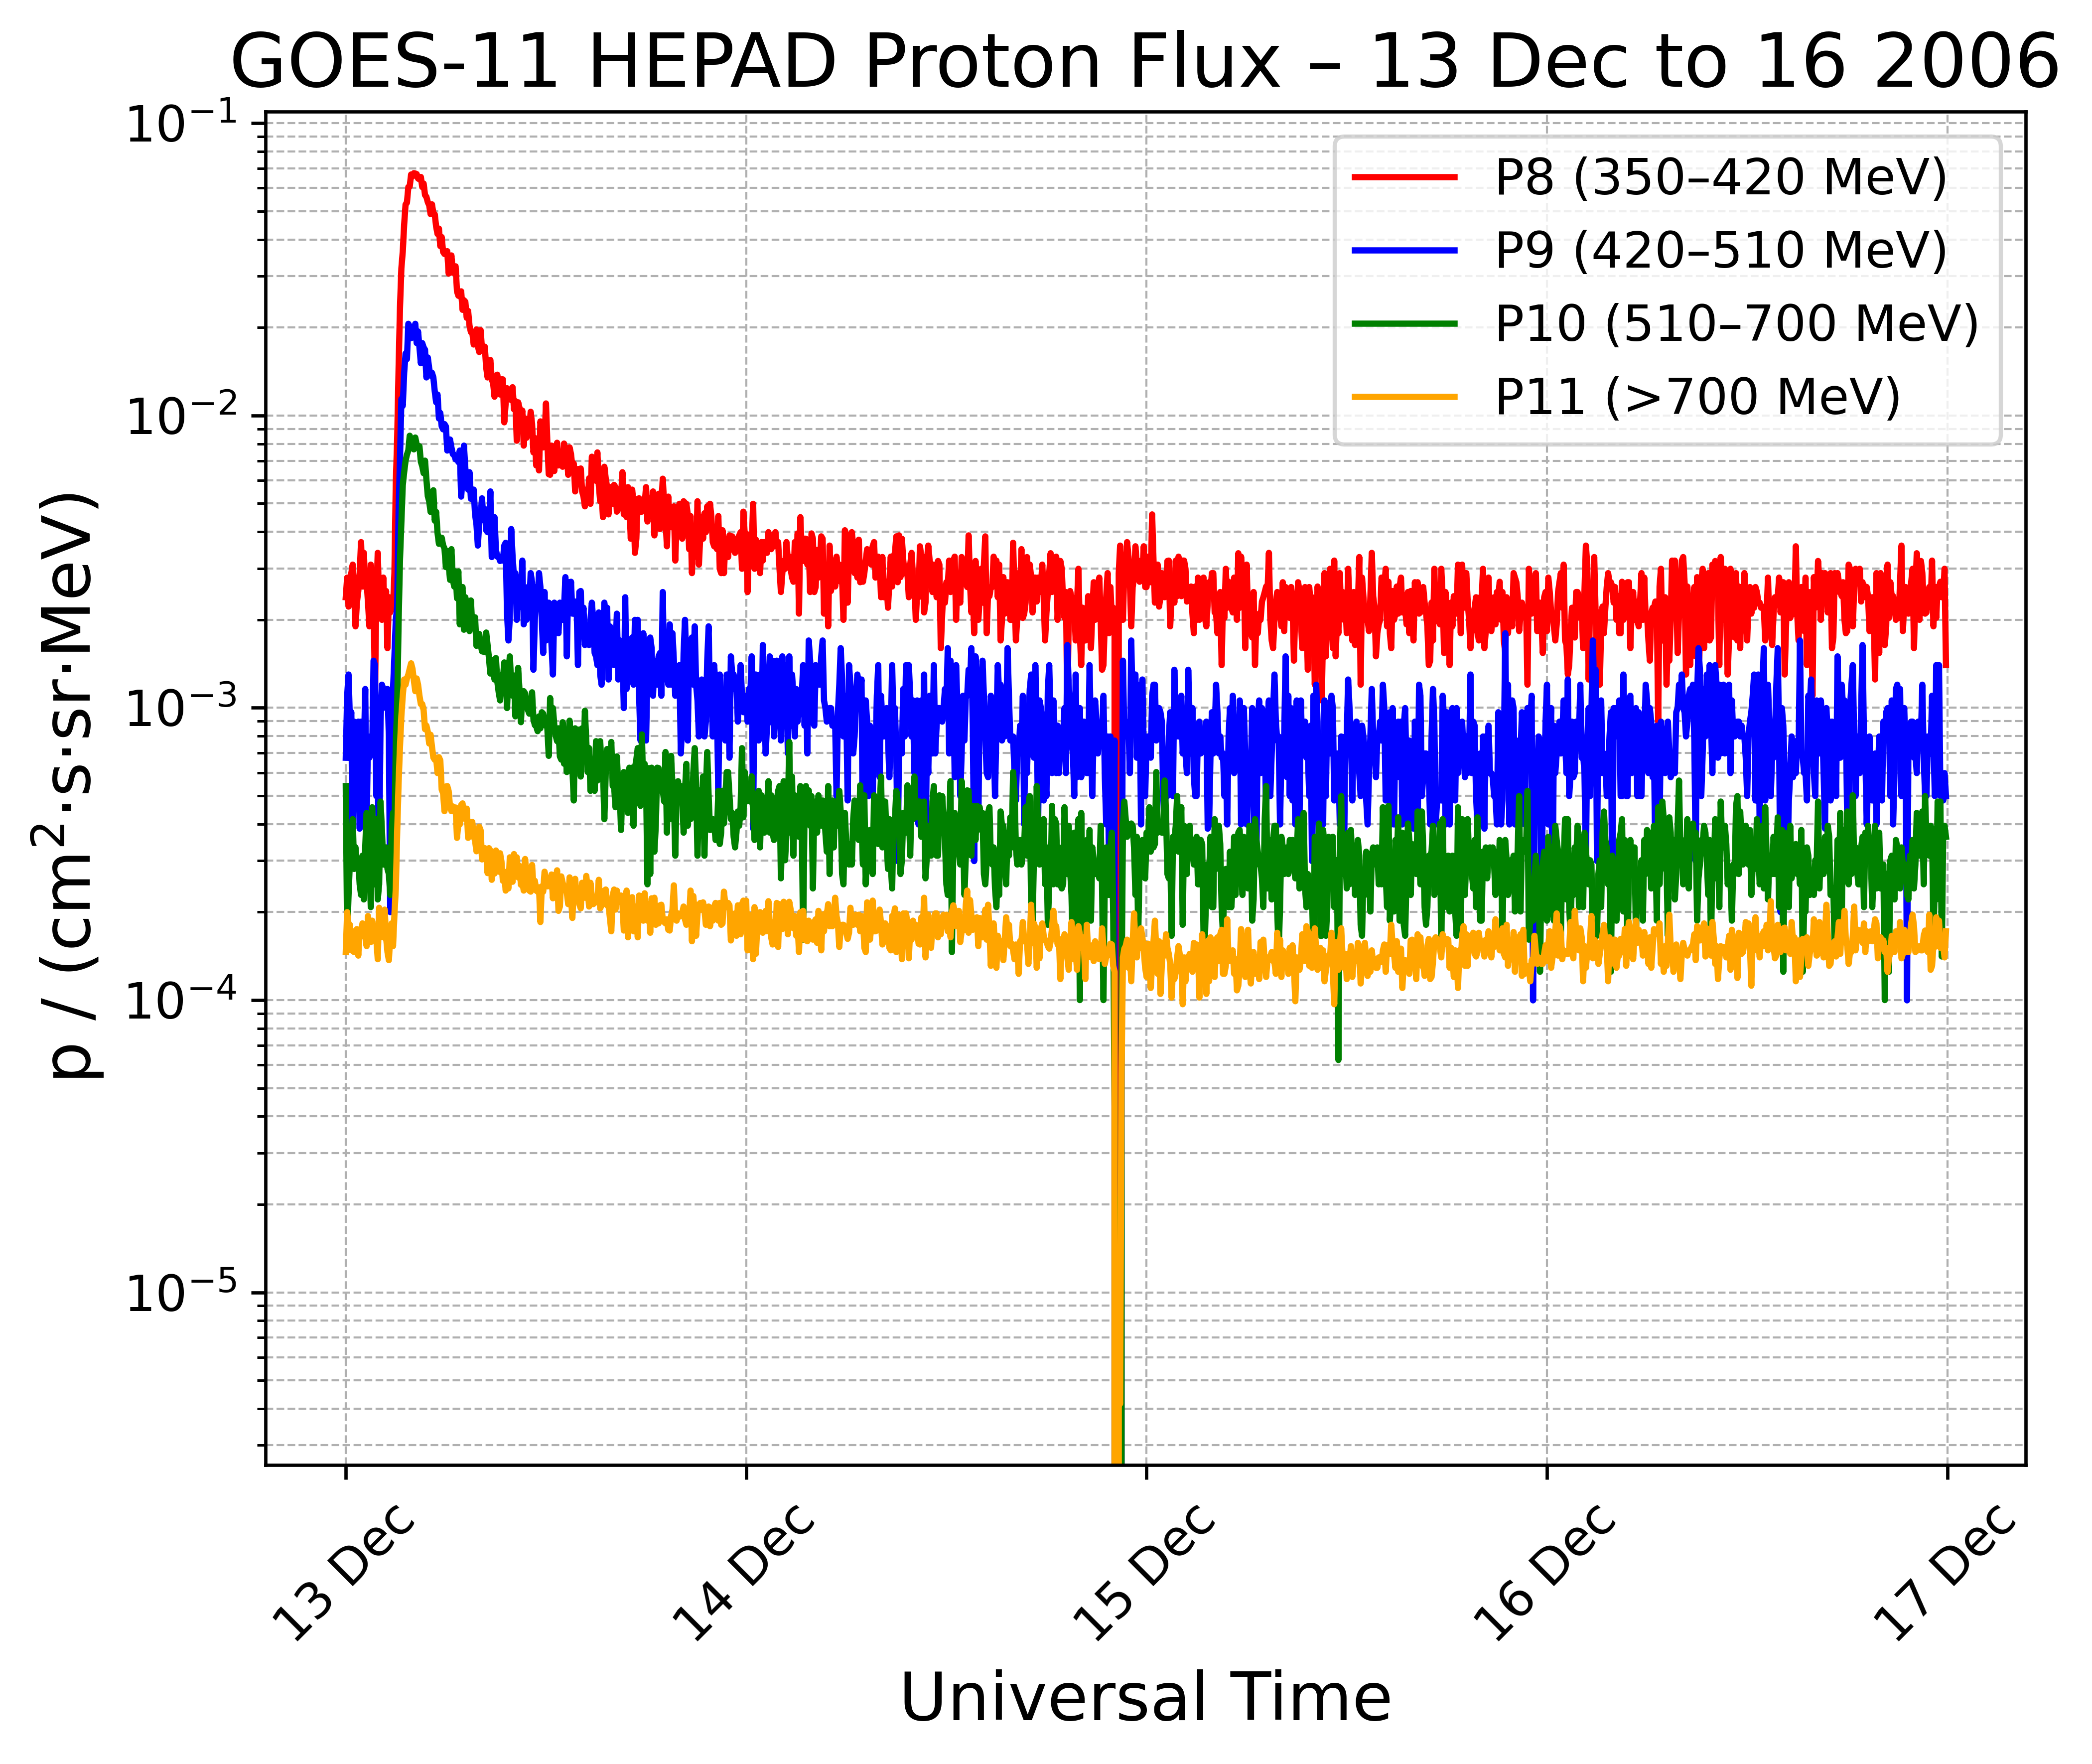

🔍 Trying GOES-12...
✅ Data downloaded for GOES-12


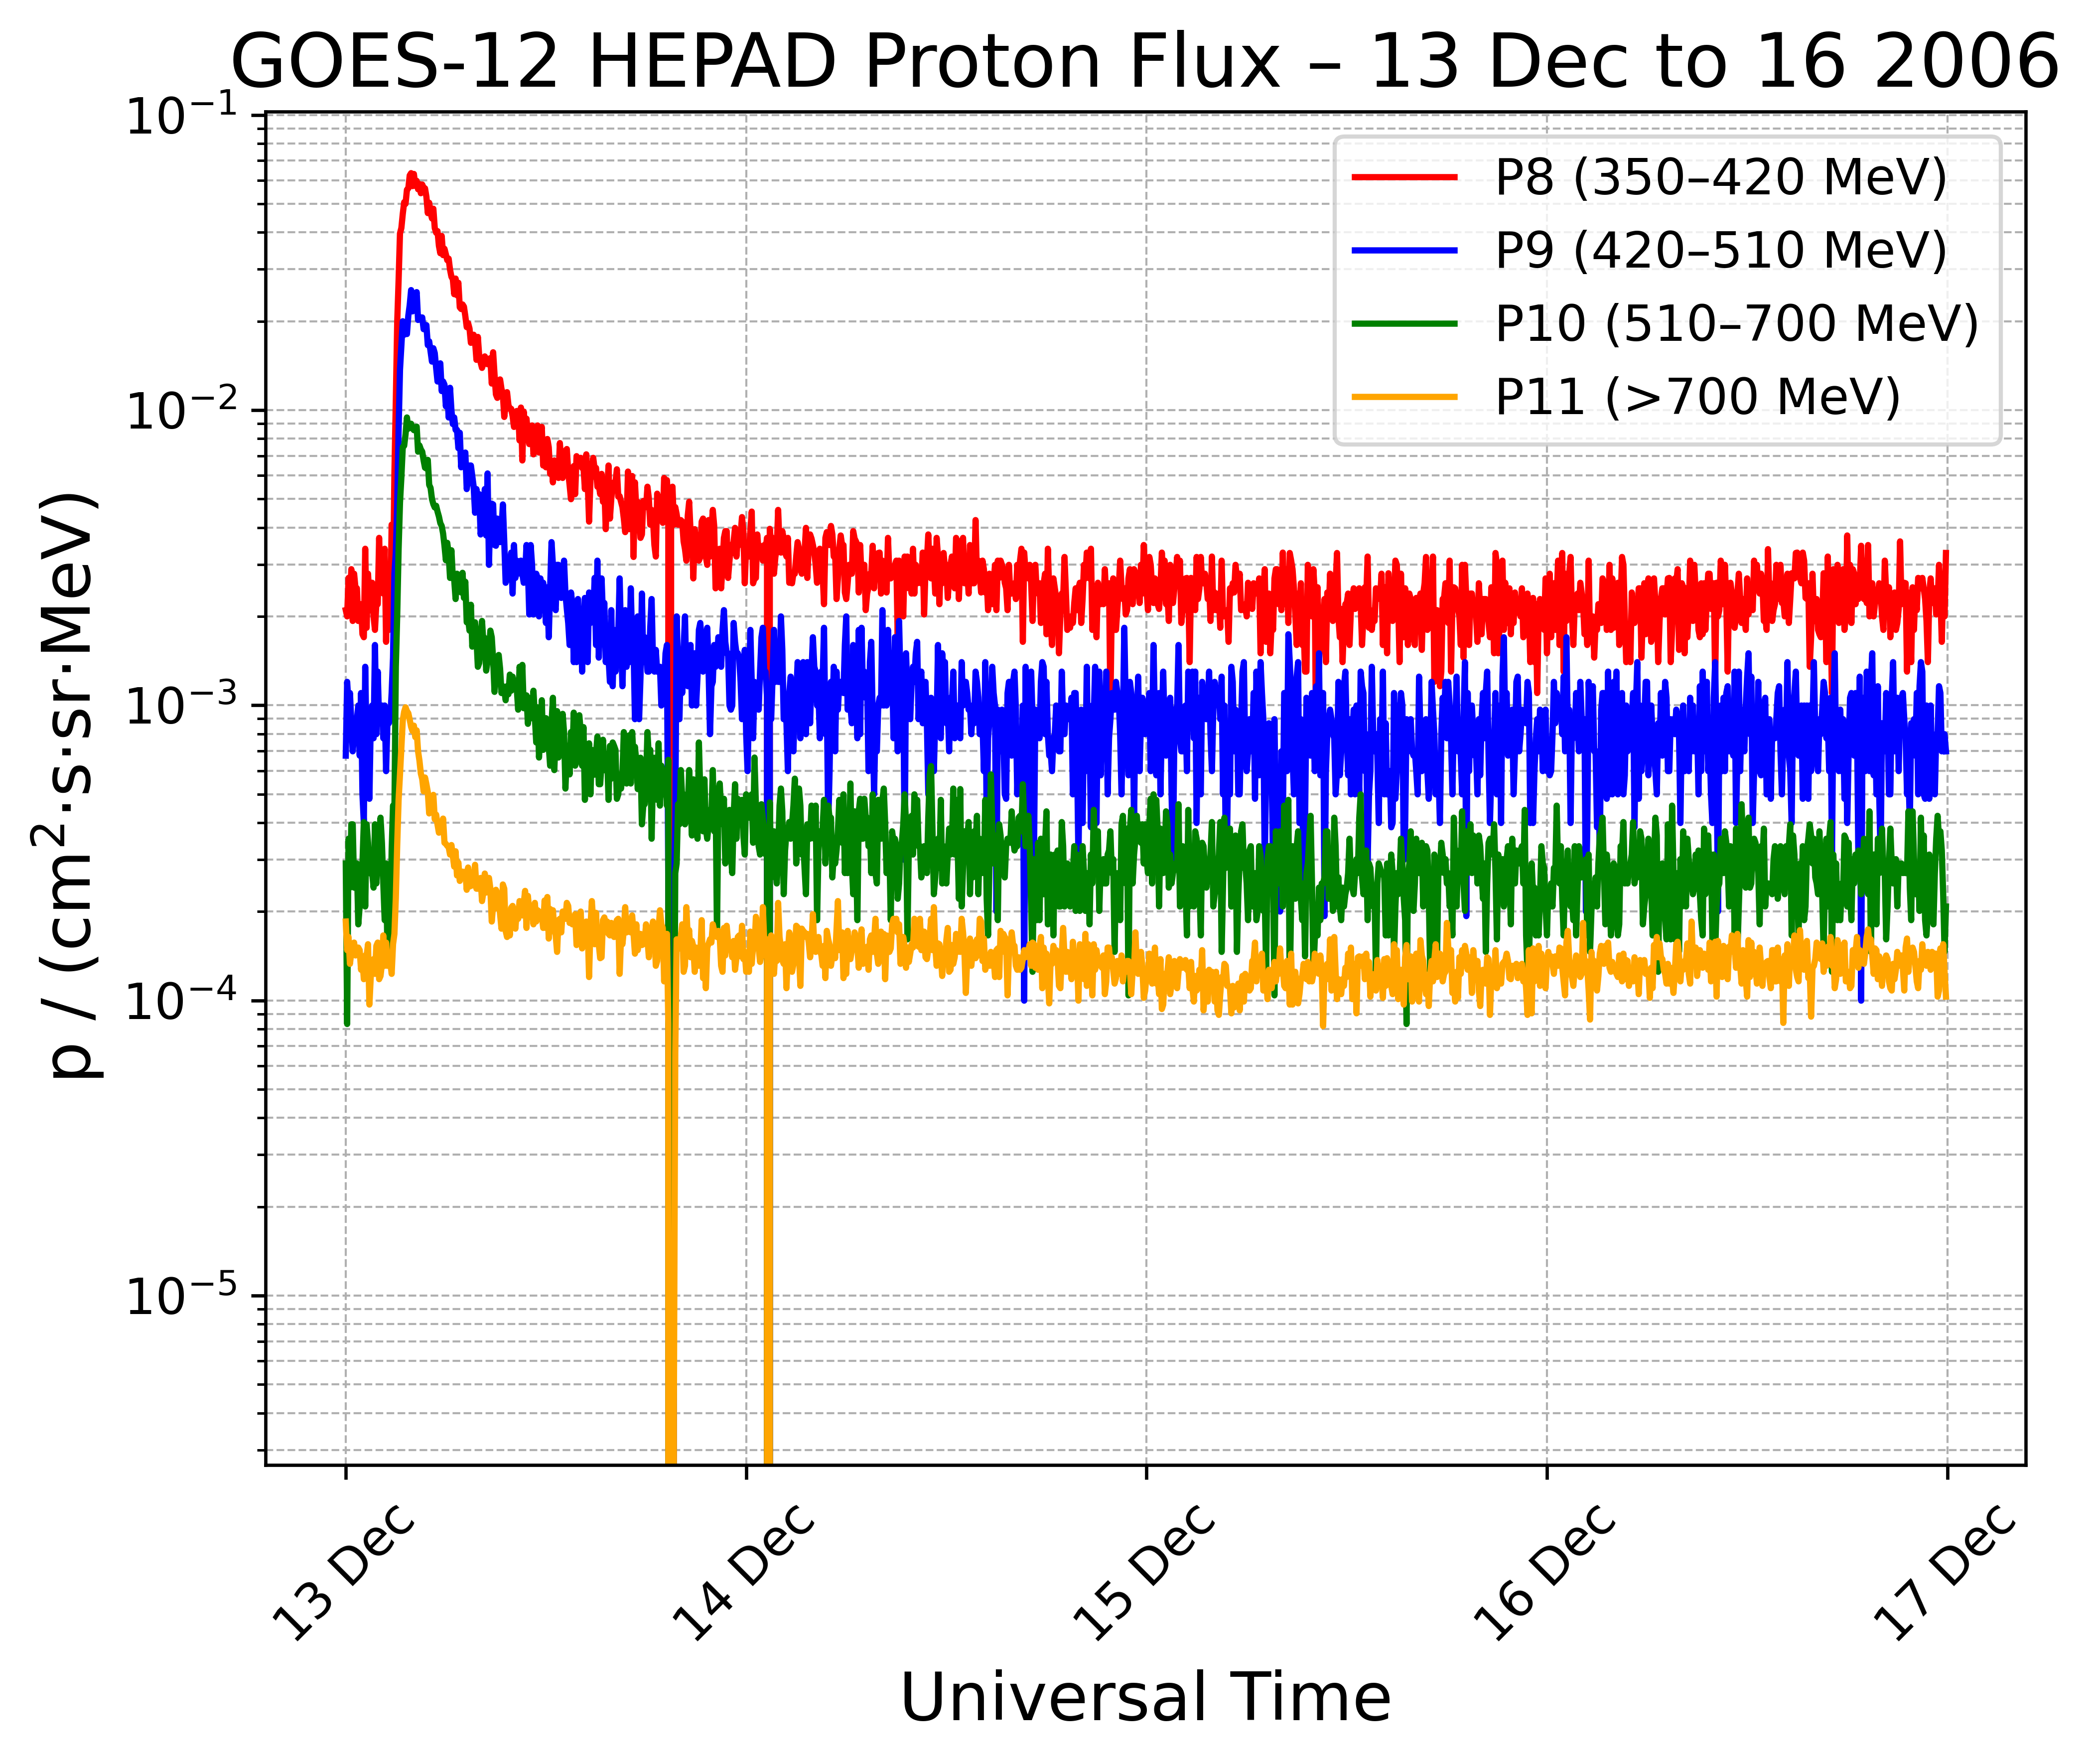

🔍 Trying GOES-13...
❌ GOES-13 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-14...
❌ GOES-14 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-15...
❌ GOES-15 not available or error: HTTP Error 404: Not Found
📄 Unit info for successfully loaded satellite:
[('10', {'p8_flux': 'p/(cm^2 s sr MeV)', 'p9_flux': 'p/(cm^2 s sr MeV)', 'p10_flux': 'p/(cm^2 s sr MeV)', 'p11_flux_i': 'p/(cm^2 s sr)'}), ('11', {'p8_flux': 'p/(cm^2 s sr MeV)', 'p9_flux': 'p/(cm^2 s sr MeV)', 'p10_flux': 'p/(cm^2 s sr MeV)', 'p11_flux_i': 'p/(cm^2 s sr)'}), ('12', {'p8_flux': 'p/(cm^2 s sr MeV)', 'p9_flux': 'p/(cm^2 s sr MeV)', 'p10_flux': 'p/(cm^2 s sr MeV)', 'p11_flux_i': 'p/(cm^2 s sr)'})]


In [4]:
# --- Loop through GOES satellites ---
satellite_logs = []
plot_made = False

for sat in range(1, 16):
    sat_str = f"{sat:02d}"
    url = (
        f"https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/"
        f"avg/{year_str}/{month_str}/goes{sat_str}/netcdf/"
        f"g{sat_str}_hepad_5m_{start_str}_{end_str}.nc"
    )
    local_path = f"g{sat_str}_hepad_5m_{start_str}_{end_str}.nc"

    try:
        print(f"🔍 Trying GOES-{sat_str}...")

        if not os.path.exists(local_path):
            urllib.request.urlretrieve(url, local_path)
            print(f"✅ Data downloaded for GOES-{sat_str}")
        else:
            print(f"📂 Using cached file for GOES-{sat_str}")

        ds = xr.open_dataset(local_path)

        # Select proton flux variables and validate
        selected_vars = ['p8_flux', 'p9_flux', 'p10_flux', 'p11_flux_i']
        available_vars = [var for var in selected_vars if var in ds.data_vars]
        if not available_vars:
            print(f"⚠️ No valid proton flux data found in GOES-{sat_str}.")
            continue

        # Time series and DataFrame
        time = pd.to_datetime(ds['time_tag'].values)
        df = pd.DataFrame({'Time': time})
        unit_info = {}

        for var in available_vars:
            df[var] = ds[var].values
            unit_info[var] = ds[var].attrs.get('units', 'N/A')


        # Filter by date range
        start_date = datetime(year, month, start_day)
        end_date_dt = datetime(year, month, end_day + 1)
        df = df[(df['Time'] >= start_date) & (df['Time'] < end_date_dt)]

        if df.empty or df[available_vars].isna().all().all():
            print(f"⚠️ GOES-{sat_str} has no valid flux data in specified range.")
            continue

        # Store unit info
        satellite_logs.append((sat_str, unit_info))

        # --- Plot ---
        plt.figure(figsize=(7, 6), dpi = 600)
        color_map = {
            'p8_flux': 'red',
            'p9_flux': 'blue',
            'p10_flux': 'green',
            'p11_flux_i': 'orange'
        }
        label_map = {
            'p8_flux': 'P8 (350–420 MeV)',
            'p9_flux': 'P9 (420–510 MeV)',
            'p10_flux': 'P10 (510–700 MeV)',
            'p11_flux_i': 'P11 (>700 MeV)'
        }

        for var in available_vars:
            plt.semilogy(df['Time'], df[var], label=label_map[var], color=color_map[var])

        plt.title(f"GOES-{sat_str} HEPAD Proton Flux – {start_date:%d %b} to {end_day} {year}", fontsize=18)
        plt.xlabel("Universal Time", fontsize=16)
        plt.ylabel("p / (cm$^2$·s·sr·MeV)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

        plot_made = True

    except Exception as e:
        print(f"❌ GOES-{sat_str} not available or error: {e}")
        continue

if not plot_made:
    print("🚫 No valid satellite data available to plot.")

# Output unit log
print("📄 Unit info for successfully loaded satellite:")
print(satellite_logs)
